# Intermediate Deep Learning concepts

In this notebook, we are going to see some slightly more advanced concepts of Deep Learning, and how they are practically implemented in pytorch.

Let's start again by importing all libraries we will need in the following.

In [1]:
!pip install openml --quiet

import openml

In [2]:
import torch
print("pytorch version:",torch.__version__)
print("Is GPU computation available?", torch.cuda.is_available())

# this is only relevant for people with a MacBook M1 and pytorch >= 2.0
print("(Mac M1 only) Is GPU computation available?", torch.backends.mps.is_available())

import matplotlib.pyplot as plt
import numpy as np
import sklearn

pytorch version: 2.5.1
Is GPU computation available? True
(Mac M1 only) Is GPU computation available? False


## Monitoring the training process with training loss and validation loss

As we have seen in the previous example, it can be difficult to exactly assess when to stop the training process for a DL model; or, in other words, how to set the proper number of iterations in the gradient descent algorithm. In practice, we would like to know exactly when our model starts overfitting the training data, and stop right before overfitting becomes a problem. However, it is impossible to assess overfitting just checking the performance on the training data: two different models might show the same performance on training data; but one could be able to generalize perfectly to unseen data, and the other could be completely overfitted and performing poorly on unseen data.

One way of tackling this problem is to further divide our training data into two parts: one training set proper and one *validation set*, that will not be used for training, but just to check performance during the training process, and identify possible signs of overfitting.

Let's load and preprocess the data, as usual.

In [3]:
dataset = openml.datasets.get_dataset(189)

df, *_ = dataset.get_data()
print(df)

# as you noticed, some of the columns contain strings instead of numbers; we call these
# "categorical" columns or features. We need to change that, as most ML algorithms
# only process numbers. Don't worry too much about this part, it's just replacing strings
# with numbers
categorical_columns = df.select_dtypes(include=['category', 'object', 'string']).columns
print("I found a total of %d categorical features." % len(categorical_columns))
for c in categorical_columns :
  df[c].replace({category : index for index, category in enumerate(df[c].astype('category').cat.categories)}, inplace=True)

# also, remove all rows that contain invalid numerical values (for example, missing values)
df.dropna(inplace=True)

# name of the target column
target_feature = dataset.default_target_attribute
other_features = [c for c in df.columns if c != target_feature]

# get just the data without the column headers, as numerical matrices
X = df[other_features].values
y = df[target_feature].values

print("X=", X)
print("y=", y)

        theta1    theta2    theta3    theta4    theta5    theta6    theta7  \
0    -0.015119  0.360741  0.469398  1.309675  0.988024 -0.025493  0.664071   
1     0.360478 -0.301395  0.629183 -1.440146 -0.741637 -1.196749 -1.038444   
2     1.563238 -1.294753  0.078987  1.432937  1.149136 -1.292140  1.562988   
3     0.199485  0.901157 -1.356304 -0.080525 -0.976628  0.829894 -0.855649   
4     0.659737  0.120552 -0.008756  0.648839  0.626832 -0.646539  1.318074   
...        ...       ...       ...       ...       ...       ...       ...   
8187  1.459523 -0.201551 -0.610721  1.424181  0.269273  1.172781 -0.509818   
8188  0.654980 -0.823516 -0.809246  0.408441 -1.368838  0.582222 -1.394697   
8189  0.103862  1.024329 -1.047221  0.280905 -0.181155 -0.651934 -1.241842   
8190 -1.109311 -0.027690 -1.448736 -0.648566 -0.462142  0.814971  1.100615   
8191  1.155010 -0.429331 -1.567260  0.883077 -1.203777 -0.126506  0.331042   

        theta8         y  
0     0.062763  0.536524  
1    -0.7

C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


This time, however, we will split the data into three parts: a training set, a validation set, and a test set.

In [4]:
from sklearn.model_selection import train_test_split
# we use 10% of the data for the test, the rest for training and validation
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
# we use 20% of the remaining data for validation, the rest for the training
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, shuffle=True, random_state=42)

print("Whole dataset: %d samples; training set: %d samples; validation set: %d samples; test set: %d samples"
% (X.shape[0], X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Whole dataset: 8192 samples; training set: 5897 samples; validation set: 1475 samples; test set: 820 samples


Normalize the data, as usual by learning the normalization on the training set and applying it to the other two sets.

In [5]:
# StandardScaler is an object that is able to learn and apply a normalization
# that reduces the values of a feature to zero mean and unitary variance
# so that most of the data values of a feature will fall into the interval (-1,1)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler() # we need a separate instance of the StandardScaler object for X and y
scaler_y = StandardScaler()

scaler_X.fit(X_train)
scaler_y.fit(y_train.reshape(-1,1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# don't worry too much about all this reshaping going on here, these function like
# to have their inputs in a particular way, but the functions later like another
# type of input, so we are forced to reshape and reshape again
y_train_scaled = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1,)
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).reshape(-1,)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1,)

# convert all the arrays to pytorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float)

print("y_train_tensor has shape:", y_train_tensor.shape)
print("y_val_tensor has shape:", y_val_tensor.shape)
print("y_test_tensor has shape:", y_test_tensor.shape)

y_train_tensor has shape: torch.Size([5897])
y_val_tensor has shape: torch.Size([1475])
y_test_tensor has shape: torch.Size([820])


Now, let's go back to our first neural network for regression.

In [6]:
# we create a new class, that inherits from torch.nn.Module, the basic pytorch module
class TwoLayerNeuralNetworkRegressor(torch.nn.Module) :

  # first, the builder __init__ that is called every time the class is instantiated
  # note that we added an additional argument, input_features_size, that we can modify
  # to adapt this to problems with a different number of features
  def __init__(self, input_features_size=8) :
    super(TwoLayerNeuralNetworkRegressor, self).__init__() # call the __init__ of the parent class Module
    self.linear_1 = torch.nn.Linear(input_features_size, 5) # linear layer, input_features_size inputs and 5 outputs
    self.activation_function_1 = torch.nn.Sigmoid() # activation function
    self.linear_2 = torch.nn.Linear(5, 1) # another linear layer, 5 inputs, 1 output (that will be intepreted as the prediction)

  # the method 'forward' describes what happens during a forward pass
  def forward(self, x) :
    z_1 = self.linear_1(x) # pass inputs through first linear module
    z_2 = self.activation_function_1(z_1) # pass output of linear layer through activation function
    y_hat = self.linear_2(z_2) # pass output of activation function through last linear TwoLayerNeuralNetwork

    # return the tensor in output of the last module as a prediction
    return y_hat

This time, your task will be to record the MSE on the validation set during the training process, and plot it at the end. What can you observe?

In [7]:
# set the random seed, as SGD uses stochastic elements
torch.manual_seed(42)

# instantiate the neural network from the class we defined above
two_layer_neural_network = TwoLayerNeuralNetworkRegressor()

# the learning_rate is the 'step' that the gradient descent will take to move in the
# search space of the parameters
learning_rate = 1e-2

# the number of 'epochs' is the number of iterations of gradient descent after
# which the algorithm will stop and return the best solution found so far
max_epochs = 100000

# we select the type of loss we are going to use; in this case, it's going to be
# Mean Squared Error (MSE), appropriate for most regression tasks
mse_loss = torch.nn.MSELoss()

# and now we can start the iterative optimization loop; we instantiate the optimizer
# Stochastic Gradient Descent (SGD) to optimize the parameters of the network
optimizer = torch.optim.SGD(params=two_layer_neural_network.parameters(), lr=learning_rate)

# some data structures here to store the training and validation loss
train_losses = np.zeros((max_epochs,))
val_losses = np.zeros((max_epochs,))

# and now we start the optimization process!
print("Starting optimization...")
for epoch in range(0, max_epochs) :
  # get the tensor containing the network predictions for the training set,
  # using the current parameters (initially, they will all be random)
  y_train_pred = two_layer_neural_network(X_train_tensor)

  # compute loss
  loss_train = mse_loss(y_train_pred, y_train_tensor.view(-1,1))
  train_losses[epoch] = loss_train.item() # .item() here access the value stored inside the tensor that mse_loss returns

  # now, here we need to also compute the loss on the validation set; we use the
  # context torch.no_grad() to skip all computations on the tensor during the
  # forward pass, we do not need to store that information for the validation set
  # TODO: you have to code this
  with torch.no_grad() :
    # TODO: change the part here to actually compute and store the validation loss
    y_val_pred = two_layer_neural_network(X_val_tensor)
    loss_val = mse_loss(y_val_pred, y_val_tensor.view(-1,1)) 
    val_losses[epoch] = loss_val.item()

  # printout on the first and last epoch, plus all epochs exactly divisible by 100
  if epoch == 0 or epoch % 100 == 0 or epoch == max_epochs-1 :
    print("Epoch %d: training loss=%.4e, validation loss=%.4e" % (epoch, loss_train, loss_val)) # this printout is run only each 100 epochs

  # set the cumulated gradients back to zero (to avoid cumulating from one epoch to the next)
  optimizer.zero_grad()
  # perform the backward operation to retropropagate the error and get the gradient
  loss_train.backward()
  # perform one step of the gradient descent, modifying the network parameters
  optimizer.step()

Starting optimization...
Epoch 0: training loss=1.1617e+00, validation loss=1.2191e+00
Epoch 100: training loss=9.7343e-01, validation loss=1.0228e+00
Epoch 200: training loss=9.3795e-01, validation loss=9.8882e-01
Epoch 300: training loss=8.9437e-01, validation loss=9.4711e-01
Epoch 400: training loss=8.4072e-01, validation loss=8.9548e-01
Epoch 500: training loss=7.8002e-01, validation loss=8.3669e-01
Epoch 600: training loss=7.1987e-01, validation loss=7.7802e-01
Epoch 700: training loss=6.6867e-01, validation loss=7.2771e-01
Epoch 800: training loss=6.3109e-01, validation loss=6.9049e-01
Epoch 900: training loss=6.0683e-01, validation loss=6.6622e-01
Epoch 1000: training loss=5.9263e-01, validation loss=6.5185e-01
Epoch 1100: training loss=5.8485e-01, validation loss=6.4386e-01
Epoch 1200: training loss=5.8074e-01, validation loss=6.3957e-01
Epoch 1300: training loss=5.7858e-01, validation loss=6.3726e-01
Epoch 1400: training loss=5.7741e-01, validation loss=6.3598e-01
Epoch 1500: 

Now we can compute the values of some metrics, and check the performance of the network.

R2 on training: 0.7880
R2 on validation: 0.7790
R2 on test: 0.7731


Text(0.5, 1.0, 'Performance on: training R2=0.7880; validation R2=0.7790; test R2=0.7731')

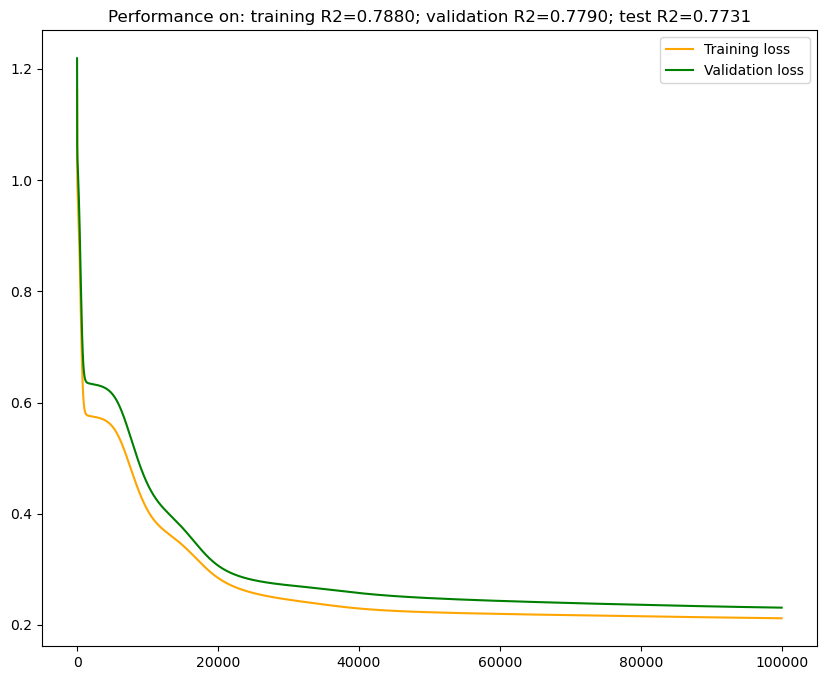

In [8]:
from sklearn.metrics import r2_score

# we do not need to store information about the derivatives or compute gradients
# to evaluate the network, so let's use the context no_grad()
with torch.no_grad() :

  # the r2_score function expects lists or numpy arrays as inputs, so we need
  # to convert the tensors to the appropriate data type before using it
  y_train_pred = two_layer_neural_network(X_train_tensor)
  r2_train = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())

  y_val_pred = two_layer_neural_network(X_val_tensor)
  r2_val = r2_score(y_val_tensor.numpy(), y_val_pred.numpy())

  y_test_pred = two_layer_neural_network(X_test_tensor)
  r2_test = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

  print("R2 on training: %.4f" % r2_train)
  print("R2 on validation: %.4f" % r2_val)
  print("R2 on test: %.4f" % r2_test)

# this is used for the x-axis of the plot
x_epochs = [i for i in range(0, max_epochs)]

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x_epochs, train_losses, color='orange', label="Training loss")
ax.plot(x_epochs, val_losses, color='green', label="Validation loss")
ax.legend(loc='best')
ax.set_title("Performance on: training R2=%.4f; validation R2=%.4f; test R2=%.4f" % (r2_train, r2_val, r2_test))

Try to play a little with the hyperparameters of the network to obtain better results. You should be able to obtain a good performance just by altering the hyperparameters of the optimizer. As a reference, here below are the basic results that you can obtain with Random Forest and XGBoost, without any hyperparameter optimization.

In [9]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Random Forest, R2_train=%.4f; R2_test=%.4f" % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print("XGBoost, R2_train=%.4f; R2_test=%.4f" % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

Random Forest, R2_train=0.9597; R2_test=0.6924
XGBoost, R2_train=0.9614; R2_test=0.7298


## Advanced monitoring and logging: Tensorboard

Tensorboard is a utility visualization tool created by TensorFlow. It is so convenient and successful that even other libraries (like pytorch) added ways to use it. At its core, Tensorboard reads logs (text files) in a specific format, resulting from the training of a neural network, and provides a graphical output. Let's try to run Tensorboard in Google Colaboratory, using a pytorch utility to write the logs.

In [10]:
import torch
from torch.utils.tensorboard import SummaryWriter

We are now going to create another instance of the `TwoLayerNeuralNetworkRegressor`, with a training loop similar to the one above; the only difference is that we now can call the `SummaryWriter` instance to write the log files that will be later read by Tensorboard to create the visualizations.

In [11]:
# set the random seed
random_seed = 424242
torch.manual_seed(random_seed)

# SummaryWriter is a class able to create logs in a format that Tensorboard can read
# we can specify a directory where the logs will be stored
folder_name = "my_great_runs/run_%d" % random_seed
writer = SummaryWriter(folder_name)

# create another instance of the class
two_layer_neural_network_2 = TwoLayerNeuralNetworkRegressor()

# set hyperparameters of the optimizer, and create another instance of the optimizer
learning_rate = 1e-1
max_epochs = 1000
optimizer_2 = torch.optim.SGD(params=two_layer_neural_network_2.parameters(), lr=learning_rate)

# another instance of the loss function, classic MSE
mse_loss_2 = torch.nn.MSELoss()

for epoch in range(0, max_epochs) :
  # get network predictions
  y_train_pred = two_layer_neural_network_2(X_train_tensor)

  # compute loss
  loss_train = mse_loss_2(y_train_pred, y_train_tensor.view(-1,1))

  # now, we write the information on the loss in the log files
  writer.add_scalar("Loss/train", loss_train, epoch)

  with torch.no_grad() :
    loss_val = loss_train # TODO: change this, add the real validation loss

    # also store the information about the validation loss
    writer.add_scalar("Loss/validation", loss_val, epoch)

  # printout on the first and last epoch, plus all epochs exactly divisible by 100
  if epoch == 0 or epoch % 100 == 0 or epoch == max_epochs-1 :
    print("Epoch %d: training loss=%.4e, validation loss=%.4e" % (epoch, loss_train, loss_val)) # this printout is run only each 100 epochs

  # set the cumulated gradients back to zero (to avoid cumulating from one epoch to the next)
  optimizer_2.zero_grad()
  # perform the backward operation to retropropagate the error and get the gradient
  loss_train.backward()
  # perform one step of the gradient descent, modifying the network parameters
  optimizer_2.step()

# 'flush' here is invoked just in case that the writer did not finish writing
# everything to disk
writer.flush()

Epoch 0: training loss=1.0510e+00, validation loss=1.0510e+00
Epoch 100: training loss=5.8522e-01, validation loss=5.8522e-01
Epoch 200: training loss=5.7408e-01, validation loss=5.7408e-01
Epoch 300: training loss=5.6990e-01, validation loss=5.6990e-01
Epoch 400: training loss=5.6167e-01, validation loss=5.6167e-01
Epoch 500: training loss=5.4515e-01, validation loss=5.4515e-01
Epoch 600: training loss=5.1688e-01, validation loss=5.1688e-01
Epoch 700: training loss=4.8037e-01, validation loss=4.8037e-01
Epoch 800: training loss=4.4459e-01, validation loss=4.4459e-01
Epoch 900: training loss=4.1571e-01, validation loss=4.1571e-01
Epoch 999: training loss=3.9494e-01, validation loss=3.9494e-01


Now that the log files of the run have been written (you can check in the 'files' part here to the side <-, you should see the folder "my_great_runs"), we can read them using Tensorboard

In [12]:
# this is necessary to run Tensorboard in Google Colaboratory, I am not sure whether
# it would work on a notbook running on a local machine, we will discover it as we go ^_^;
%load_ext tensorboard
%tensorboard --logdir my_great_runs

Reusing TensorBoard on port 6006 (pid 22484), started 0:05:15 ago. (Use '!kill 22484' to kill it.)

Going back to the cell with the training loop, you can try launching another training run **changing the random seed** (maybe also with different hyperparameters, and/or adding the proper code for the validation loss). The Tensorboard should update with the separate results of the second run, so that you can compare performance.

Don't rerun the cell above, just click on the "reload" button in the top right corner of the Tensorflow graphical user interface.

## (Really) Stochastic optimization

We will now step into modern optimization of neural network parameters using (really) Stochastic Gradient Descent and its descendants. Now, as we have seen during class, the stochasticity comes from only evaluating the loss function on a subset of samples from the training set (called **batch**) before updating the weights with the information coming from the corresponding gradient.

Now, luckily for us, we won't have to hand-code the functions and classes to generate and load batches given a data set. However, pytorch philosophy is to create new classes that inherit from others, so unsurprisingly we will have to create a new class for the Dataset. The `torch.data.utils.Dataset` is the class we will inherit from. Just as when we were inheriting from `torch.nn.Module` we had to specify the builder `__init__()` and the `forward()` method, for this inheritance we will have to specify `__len__()` that returns that total number of samples in the data set, and `__getitem__(index)` that returns a single sample in the dataset, in position `index`. You might notice that the names of both functions start with `__`, which in Python marks them as special methods. While they can both called directly, `object.__len__()` is also invoked when a `len(object)` is called, while `object.__getitem__(index)` is invoked when `object[index]` is called.

In [13]:
# here is our new class, inheriting from Dataset; it is supposed to be a generic
# class to load data sets obtained from openml
class OpenMLDataset(torch.utils.data.Dataset) :

  # we create our own builder, that has two compulsory arguments, X (tensor with feature values)
  # and y (tensor with values of the target)
  def __init__(self, X, y) :
    # call __init__ of the parent class (in this case, the parent class has no __init__, but this is an implementation detail)
    super(OpenMLDataset, self).__init__()
    # we store the information internally in the object, as two attributes self.X and self.y
    self.X = X
    self.y = y

  # the function that returns the total number of samples is easy
  def __len__(self) :
    return self.y.shape[0]

  # the function that gets a single sample is also pretty straightforward
  def __getitem__(self, index) :
    return self.X[index], self.y[index]

# fantastic! now we can instantiate our OpenMLDataset class, and use it to store
# the training, validation and test set we created above
train_data = OpenMLDataset(X_train_tensor, y_train_tensor)
val_data = OpenMLDataset(X_val_tensor, y_val_tensor)
test_data = OpenMLDataset(X_test_tensor, y_test_tensor)

# let's give it a trial run
print("Samples in the training set:", len(train_data)) # here len() calls the __len__() method of the object
print("Samples in the validation set:", len(val_data))
print("Samples in the test set:", len(test_data))

Samples in the training set: 5897
Samples in the validation set: 1475
Samples in the test set: 820


Now, we are going to use `DataLoader` objects to manage the batches. `DataLoader` accepts several arguments in the builder, that are pretty self-explanatory.   

In [14]:
# the 'shuffle' option here is whether the samples should be returned in a random order;
# it only makes sense for the training data, from which we will obtain the loss information
load_train = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
# we don't really need a data loader for the validation or test set, as we will just use them in one go

# but in practice, what happens when we ask the DataLoaders to give us some samples?
# let's check!
for X_batch, y_batch in load_train :
  print("The load_train DataLoader gave me a batch of %d samples" % X_batch.shape[0])

The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 samples
The load_train DataLoader gave me a batch of 64 

Calling a DataLoader like we did in the code cell above will return a series of batches of the specified size, until all the data set has been seen. As you might have noticed, the last batch in the set is smaller than the rest, as the amount of data we got was not exactly divisible by the batch size. Now, let's rewrite the optimization loop, this time using the DataLoaders we just created to update the gradient after each batch.

In [15]:
# set the random seed
random_seed = 42424242
torch.manual_seed(random_seed)

# SummaryWriter is a class able to create logs in a format that Tensorboard can read
# we can specify a directory where the logs will be stored
folder_name = "my_great_runs/run_%d" % random_seed
writer = SummaryWriter(folder_name)

# create another instance of the class
two_layer_neural_network_3 = TwoLayerNeuralNetworkRegressor()

# set hyperparameters of the optimizer, and create another instance of the optimizer
learning_rate = 5e-3 # let's use a lower learning rate, for smaller steps
max_epochs = 500
#optimizer_3 = torch.optim.SGD(params=two_layer_neural_network_3.parameters(), lr=learning_rate)
optimizer_3 = torch.optim.Adam(params=two_layer_neural_network_3.parameters(), lr=learning_rate)

# another instance of the loss function, classic MSE
mse_loss_3 = torch.nn.MSELoss()

for epoch in range(0, max_epochs) :

  # now, instead of just using the whole training set, we will work through batches
  all_loss_batches = [] # let's keep track of loss of each batch
  for X_batch, y_batch in load_train :

    # get network predictions and compute loss
    y_batch_pred = two_layer_neural_network_3(X_batch)
    loss_batch = mse_loss_3(y_batch.view(-1,1), y_batch_pred)

    # store information on the loss
    all_loss_batches.append(loss_batch.item())

    # update gradients and perform a step of the optimizer
    optimizer_3.zero_grad() # set all information on gradients for parameters in the network to zero
    loss_batch.backward() # use information from the loss_batch to backpropagate gradients on parameters
    optimizer_3.step() # update weights in the opposite direction of the gradient

  # now, we write the information on the average loss for all the batches
  loss_train = np.mean(all_loss_batches)
  writer.add_scalar("Loss/train", loss_train, epoch)

  with torch.no_grad() :
    loss_val = loss_train # TODO: change this, add the real validation loss

    # also store the information about the validation loss
    writer.add_scalar("Loss/validation", loss_val, epoch)

  # printout on the first and last epoch, plus all epochs exactly divisible by 100
  if epoch == 0 or epoch % 10 == 0 or epoch == max_epochs-1 :
    print("Epoch %d: training loss (mean over batch)=%.4e, validation loss=%.4e" % (epoch, loss_train, loss_val)) # this printout is run only each 100 epochs


# 'flush' here is invoked just in case that the writer did not finish writing
# everything to disk
writer.flush()

Epoch 0: training loss (mean over batch)=8.2978e-01, validation loss=8.2978e-01
Epoch 10: training loss (mean over batch)=3.7739e-01, validation loss=3.7739e-01
Epoch 20: training loss (mean over batch)=2.5044e-01, validation loss=2.5044e-01
Epoch 30: training loss (mean over batch)=2.3461e-01, validation loss=2.3461e-01
Epoch 40: training loss (mean over batch)=2.2939e-01, validation loss=2.2939e-01
Epoch 50: training loss (mean over batch)=2.2414e-01, validation loss=2.2414e-01
Epoch 60: training loss (mean over batch)=2.2620e-01, validation loss=2.2620e-01
Epoch 70: training loss (mean over batch)=2.2196e-01, validation loss=2.2196e-01
Epoch 80: training loss (mean over batch)=2.1918e-01, validation loss=2.1918e-01
Epoch 90: training loss (mean over batch)=2.1905e-01, validation loss=2.1905e-01
Epoch 100: training loss (mean over batch)=2.1692e-01, validation loss=2.1692e-01
Epoch 110: training loss (mean over batch)=2.1831e-01, validation loss=2.1831e-01
Epoch 120: training loss (m

Now, try replacing the optimizer with one of the most recent ones, for example `Adam`, cutting and pasting the code below into the appropriate place of the cell above. How does it look like? More or less effective than SGD?

```
optimizer_3 = torch.optim.Adam(params=two_layer_neural_network_3.parameters(), lr=learning_rate)
```

As a final exercise, try using a scheduler to dynamically adjust the learning rate at each iteration. In pytorch, this is relatively easy: we first create an instance of the scheduler, and assign it to the instance of the optimizer:

```
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_3, gamma=0.9)
```

And then, at the end of each iteration, we call a method from the scheduler instance to update the hyperparameters of the optimizer:

```
for epoch in range(0, max_epochs) :
  ...
  # end of the loop
  scheduler.step()
```

## Checkpointing
Here below we have the same code for the network above, just rearranged in a different way. First, an initialization.

In [16]:
# set the random seed
random_seed = 123456
torch.manual_seed(random_seed)

# create another instance of the class (we are going to overwrite the first networks and other variables we used in the first cells)
two_layer_neural_network = TwoLayerNeuralNetworkRegressor()

# set hyperparameters of the optimizer, and create another instance of the optimizer
learning_rate = 1e-2
max_epochs = 50
optimizer = torch.optim.SGD(params=two_layer_neural_network.parameters(), lr=learning_rate)

# instance of the loss function
mse_loss = torch.nn.MSELoss()

# writer
folder_name = "my_great_runs/run_%d" % random_seed
writer = SummaryWriter(folder_name)

Then, here below, the code for the optimization. For the moment, do not modifiy the hyperparameters, try just running the cell with the optimization process below **multiple times**. What do you notice? What is happening here?

In [17]:
for epoch in range(0, max_epochs) :

  # now, instead of just using the whole training set, we will work through batches
  all_loss_batches = [] # let's keep track of loss of each batch
  for X_batch, y_batch in load_train :

    # get network predictions and compute loss
    y_batch_pred = two_layer_neural_network(X_batch)
    loss_batch = mse_loss(y_batch.view(-1,1), y_batch_pred)

    # store information on the loss
    all_loss_batches.append(loss_batch.item())

    # update gradients and perform a step of the optimizer
    optimizer.zero_grad() # set all information on gradients for parameters in the network to zero
    loss_batch.backward() # use information from the loss_batch to backpropagate gradients on parameters
    optimizer.step() # update weights in the opposite direction of the gradient

  # now, we write the information on the average loss for all the batches
  loss_train = np.mean(all_loss_batches)
  writer.add_scalar("Loss/train", loss_train, epoch)

  with torch.no_grad() :
    loss_val = loss_train # TODO: change this, add the real validation loss

    # also store the information about the validation loss
    writer.add_scalar("Loss/validation", loss_val, epoch)

  # printout on the first and last epoch, plus all epochs exactly divisible by 100
  if epoch == 0 or epoch % 10 == 0 or epoch == max_epochs-1 :
    print("Epoch %d: training loss (mean over batches)=%.4e, validation loss=%.4e" % (epoch, loss_train, loss_val)) # this printout is run only each 100 epochs


# 'flush' here is invoked just in case that the writer did not finish writing
# everything to disk
writer.flush()

Epoch 0: training loss (mean over batches)=1.0024e+00, validation loss=1.0024e+00
Epoch 10: training loss (mean over batches)=5.8744e-01, validation loss=5.8744e-01
Epoch 20: training loss (mean over batches)=5.7450e-01, validation loss=5.7450e-01
Epoch 30: training loss (mean over batches)=5.6773e-01, validation loss=5.6773e-01
Epoch 40: training loss (mean over batches)=5.5584e-01, validation loss=5.5584e-01
Epoch 49: training loss (mean over batches)=5.3749e-01, validation loss=5.3749e-01


A neural network can **restart the training** from the values it obtained at the end of a previous optimization run. This is very useful, as it makes it possible to train a network through successive optimization runs, and even **saving intermediate results**, commonly called "checkpoints".

Of course, pytorch offers some ways of saving and loading the weights of a network. You can even load the weights of a network inside a new network, but the two have to have the same architecture, same name of the modules, etc. In other words: they have to be two instances of the same torch.nn.Module class. Try the cell code below. It will save the weights of the neural network model we trained in the cell above, create a new instance, and then load the saved weights in the new instance. On Google Colaboratory, the file will be saved on your temporary storage (that you can access from the folder icon in the left-hand menu, 4th icon from the top).



In [18]:
state_to_be_saved = {'model_state' : two_layer_neural_network.state_dict()} # .state_dict() is a dictionary with all the values of the parameters
print("Trained weights:", two_layer_neural_network.state_dict())

# we can save it to a file using a pytorch function
torch.save(state_to_be_saved, "super_awesome_regressor")

# now, we can instantiate a new network, from the same class
totally_new_network = TwoLayerNeuralNetworkRegressor()
# and we can check that it does have different parameters, at this point randomly initialized
print("Untrained weights:", totally_new_network.state_dict())
# but by loading the old parameter into the new network, we will find the initial values again
state_from_file = torch.load("super_awesome_regressor")
totally_new_network.load_state_dict(state_from_file["model_state"])
print("Weights loaded from file:", totally_new_network.state_dict())

Trained weights: OrderedDict([('linear_1.weight', tensor([[ 0.0920,  0.2353,  0.2146,  0.5057, -0.5477,  0.8637,  0.7757, -0.4318],
        [ 0.0485,  0.0430,  0.0479,  0.3075, -0.1971, -0.2305, -0.2235, -0.1599],
        [-0.0275, -0.1768, -0.4325, -0.0444,  0.0832,  0.1365,  0.1698,  0.2010],
        [-0.3471, -0.1663, -1.0871, -0.0277,  0.0863, -0.1230, -0.2972, -0.0583],
        [ 0.1687, -0.0776,  0.8765,  0.0517, -0.5978, -0.0572, -0.1697, -0.0186]])), ('linear_1.bias', tensor([-0.4968,  0.0379, -0.1541,  0.1727,  0.1682])), ('linear_2.weight', tensor([[-1.0517, -0.0700,  0.2810,  1.2463, -0.9923]])), ('linear_2.bias', tensor([0.1999]))])
Untrained weights: OrderedDict([('linear_1.weight', tensor([[ 0.1386, -0.0908,  0.1702, -0.0786,  0.0636, -0.3361, -0.1538, -0.0023],
        [ 0.0043,  0.2562,  0.2843,  0.0222,  0.2067, -0.2200, -0.2733, -0.0412],
        [-0.1633, -0.1426,  0.0449, -0.0559,  0.1476, -0.2340, -0.3050,  0.1927],
        [ 0.3072,  0.3124,  0.1129, -0.2537, -0.0

C:\Users\Alberto\AppData\Local\Temp\ipykernel_4852\1164597682.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_from_file = torch.load("super_awesome_regressor")


If we are using one of the optimizers with internal parameters (for example, keeping track of the history of gradient values and so on), we can also save the current state of the optimizer, to restart the optimization exactly from where we left it.

In [19]:
# in general, we can add further information as other keys in the dictionary
state_to_be_saved["optimizer_state"] = optimizer.state_dict()
print("Optimizer parameters:", optimizer.state_dict())

# the same is true for schedulers, and probably other utilities
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
print("Scheduler parameters:", scheduler.state_dict())

Optimizer parameters: {'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}
Scheduler parameters: {'gamma': 0.9, 'base_lrs': [0.01], 'last_epoch': 0, 'verbose': False, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.01]}
